In [1]:
# TODO: revert to ludwig-ai repo when issue #1885 fixed
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
#!python -m pip install git+https://github.com/ludwig-ai/ludwig.git --quiet

!python -m pip install git+https://github.com/jimthompson5802/ludwig.git@fix-iss1885-roc-curve-viz-error  --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 398 kB 5.1 MB/s 
     |████████████████████████████████| 47 kB 4.0 MB/s 
     |████████████████████████████████| 136 kB 46.6 MB/s 
     |████████████████████████████████| 1.1 MB 67.5 MB/s 
     |████████████████████████████████| 94 kB 552 kB/s 
     |████████████████████████████████| 144 kB 70.7 MB/s 
     |████████████████████████████████| 271 kB 74.5 MB/s 


In [2]:
!ludwig datasets download adult_census_income

NumExpr defaulting to 2 threads.
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5rc2 - Datasets download



In [3]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('./adult_census_income.csv')
raw_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,split
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [4]:
config_yaml = """
preprocessing:
  number:
    normalization: zscore
    missing_value_strategy: fill_with_mean

input_features:
  - name: age
    type: number
  - name: workclass
    type: category
  - name: fnlwgt
    type: number
  - name: education
    type: category
  - name: education-num
    type: number
  - name: marital-status
    type: category
  - name: occupation
    type: category
  - name: relationship
    type: category
  - name: race
    type: category
  - name: sex
    type: category
  - name: capital-gain
    type: number
  - name: capital-loss
    type: number
  - name: hours-per-week
    type: number
  - name: native-country
    type: category

combiner:
  type: concat
  num_fc_layers: 3
  output_size: 128
  dropout: 0.2

output_features:
  - name: income
    type: binary
    preprocessing:
      fallback_true_label: " >50K"
    num_fc_layers: 4
    output_size: 32

trainer:
  epochs: 10
  optimizer: 
    type: adam
"""

# Writes config to a file called "config.yaml"
with open("config.yaml", "w") as f:
  f.write(config_yaml)

In [5]:
# Runs Ludwig train a model. This cell might take a few minutes.
!ludwig train --dataset adult_census_income.csv \
              --config config.yaml

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5rc2 - Train


╒════════════════════════╕
│ EXPERIMENT DESCRIPTION │
╘════════════════════════╛

╒══════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ experiment                                                                 │
├──────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                        │
├──────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/experiment_run                                            │
├──────────────────┼────────────────────────────

In [6]:
# Extract subset of test data for evaluation due to limitations in amount of data displayable in colab notebook.
np.random.seed(13)
raw_df.loc[raw_df.split == 2].sample(n=1000).to_csv('evaluation_dataset.csv', index=False)

Note: Due to the potential volume of output from the evaluate command for a binary output feature, cell magic %%capture is used to disable output from the next cell. To see output, execute this command in the cell after the `ludwig evaluate` command.
```
print(capt.stdout)
```

In [7]:
%%capture capt
# Generates predictions and performance statistics for the test set.
!ludwig evaluate --model_path results/experiment_run/model \
                 --dataset evaluation_dataset.csv \
                 --output_directory test_results

In [ ]:
# uncomment the next statement to see output from the ludwig evaluate command
# print(capt.stdout)

# Visualize Metrics

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt


NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'


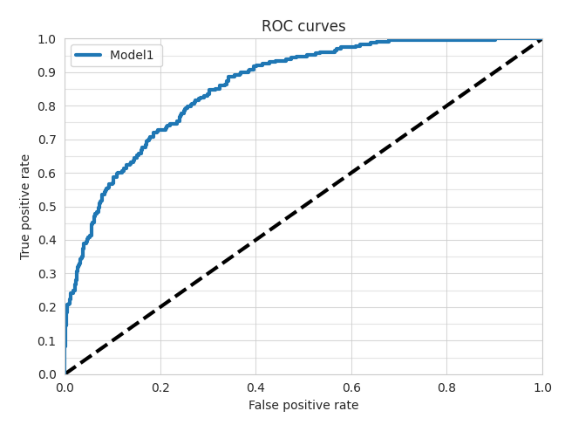

In [9]:
!ludwig visualize --visualization roc_curves \
                  --ground_truth evaluation_dataset.csv \
                  --ground_truth_metadata results/experiment_run/model/training_set_metadata.json \
                  --probabilities test_results/predictions.parquet \
                  --output_feature_name income \
                  --output_directory visualizations \
                  --model_names Model1 \
                  --file_format png

# retrieve the generated plot to display
fig, ax = plt.subplots(figsize=(10,14))
plt.imshow(plt.imread("visualizations/roc_curves.png"))
ax.axis("off")
plt.show()

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'


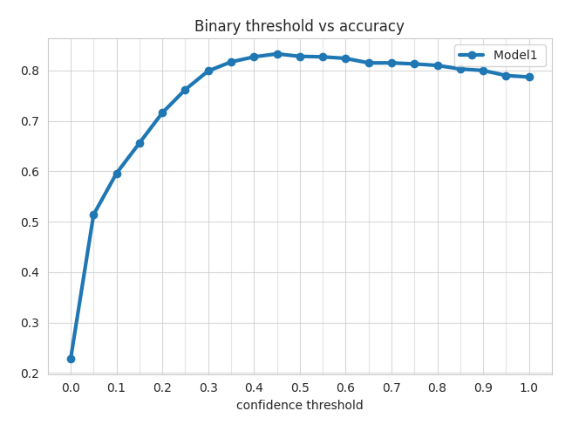

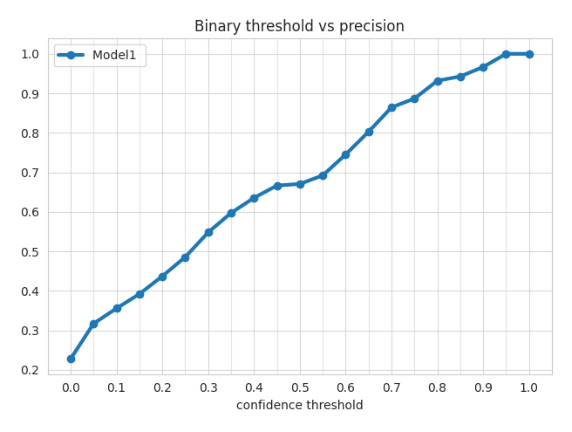

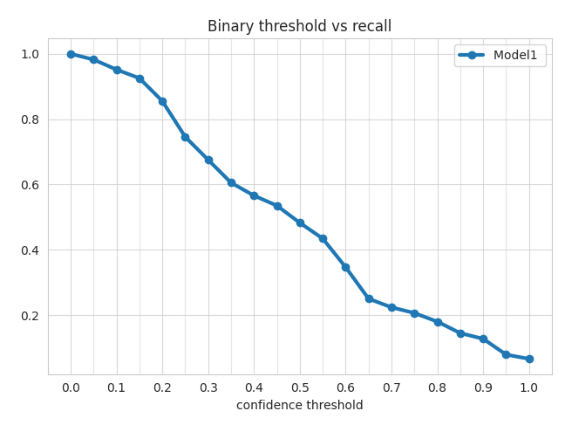

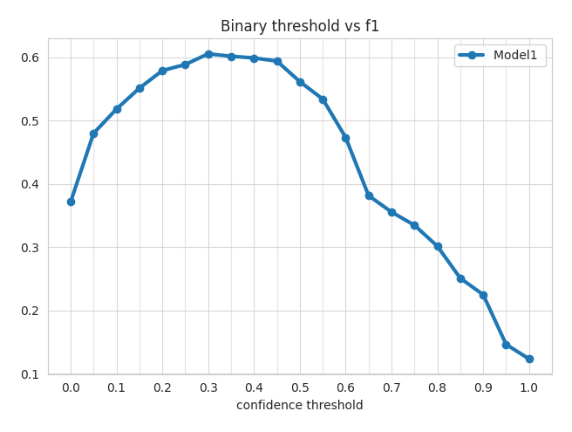

In [10]:
!ludwig visualize --visualization binary_threshold_vs_metric \
                  --ground_truth evaluation_dataset.csv \
                  --ground_truth_metadata results/experiment_run/model/training_set_metadata.json \
                  --probabilities test_results/predictions.parquet \
                  --output_feature_name income \
                  --positive_label 1 \
                  --output_directory visualizations \
                  --model_names Model1 \
                  --metrics accuracy precision recall f1\
                  --file_format png

# retrieve the generated plot to display
plot_fps = ["visualizations/binary_threshold_vs_metric_accuracy.png",
            "visualizations/binary_threshold_vs_metric_precision.png",
            "visualizations/binary_threshold_vs_metric_recall.png",
            "visualizations/binary_threshold_vs_metric_f1.png"]
for plot_fp in plot_fps:
  fig, ax = plt.subplots(figsize=(10,14))
  plt.imshow(plt.imread(plot_fp))
  ax.axis("off")
  plt.show()